# Necessary imports and settings

In [250]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import statsmodels
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal

In [251]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [252]:
data_path = "/content/drive/MyDrive/PK Data Science/master/codes/water_availability_prediction_in_Italy/data/"

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Arno River Information

Information about Arno river. The Arno is the second largest river in peninsular Italy and the main waterway in Tuscany and it  has a relatively torrential regime, 
due to the nature of the surrounding soils (marl and impermeable clays)

Output: Hydrometry_Nave_di_Rosano

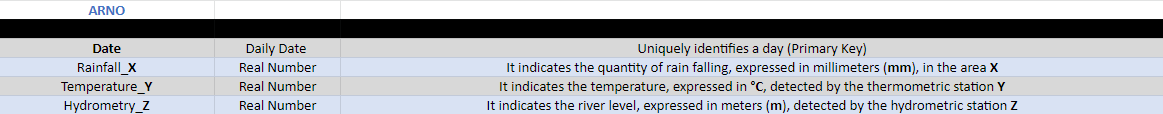

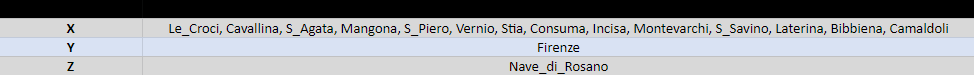

# Load data do DataFrame 

In [254]:
river_arno_csv_name = "River_Arno.csv"
df = pd.read_csv(data_path+river_arno_csv_name)

# Basic data statistics

In [255]:
df.columns.size

17

In [256]:
df.describe()

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
count,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,4283.000000,1283.000000,1283.000000,4568.000000,1647.000000,1283.00000,1283.000000,2378.000000,1283.000000,6192.000000,8169.000000
mean,3.129871,2.674743,2.670063,3.340657,2.471225,3.416437,2.538893,3.416680,2.335026,2.056709,2.42650,2.101949,2.640959,3.826968,16.605386,1.472407
std,8.025121,7.655847,7.166643,8.903134,6.650012,9.425358,6.502917,8.938863,6.347652,6.117967,7.23414,6.377879,7.161416,9.591337,7.458951,0.616259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-2.700000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,10.650000,1.100000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,16.350000,1.300000
75%,1.200000,0.600000,1.200000,1.400000,0.800000,1.200000,1.000000,2.200000,0.800000,0.600000,0.70000,0.400000,1.200000,2.400000,22.700000,1.690000
max,88.400000,113.600000,120.200000,110.000000,80.600000,126.000000,63.000000,114.400000,102.200000,75.000000,123.20000,95.600000,77.400000,103.600000,34.900000,6.750000


In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8217 entries, 0 to 8216
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8217 non-null   object 
 1   Rainfall_Le_Croci          6026 non-null   float64
 2   Rainfall_Cavallina         6026 non-null   float64
 3   Rainfall_S_Agata           6026 non-null   float64
 4   Rainfall_Mangona           6026 non-null   float64
 5   Rainfall_S_Piero           6026 non-null   float64
 6   Rainfall_Vernio            4283 non-null   float64
 7   Rainfall_Stia              1283 non-null   float64
 8   Rainfall_Consuma           1283 non-null   float64
 9   Rainfall_Incisa            4568 non-null   float64
 10  Rainfall_Montevarchi       1647 non-null   float64
 11  Rainfall_S_Savino          1283 non-null   float64
 12  Rainfall_Laterina          1283 non-null   float64
 13  Rainfall_Bibbiena          2378 non-null   float

In [258]:
df.isnull().sum()

Date                            0
Rainfall_Le_Croci            2191
Rainfall_Cavallina           2191
Rainfall_S_Agata             2191
Rainfall_Mangona             2191
Rainfall_S_Piero             2191
Rainfall_Vernio              3934
Rainfall_Stia                6934
Rainfall_Consuma             6934
Rainfall_Incisa              3649
Rainfall_Montevarchi         6570
Rainfall_S_Savino            6934
Rainfall_Laterina            6934
Rainfall_Bibbiena            5839
Rainfall_Camaldoli           6934
Temperature_Firenze          2025
Hydrometry_Nave_di_Rosano      48
dtype: int64

# Convert index to datetime

In [259]:
df.index = pd.to_datetime(df.Date)

In [260]:
df=df.drop(['Date'], axis=1)

# Features engineering

In [261]:
def feature_engineering(df):
    df["Day"] = df.index.day
    df["Month"] = df.index.month
    df["Year"] = df.index.year
    df["DayOfYear"] = df.index.dayofyear
    df["WeekOfYear"] = df.index.weekofyear

    
    return df

In [262]:
df.index.min(), df.index.max()

(Timestamp('1998-01-01 00:00:00'), Timestamp('2020-12-06 00:00:00'))

In [263]:
df_date_range = pd.date_range(start='1998-01-01', end='2020-12-06')
list_of_missing_dates = df_date_range.difference(df.index)
df_missing = pd.DataFrame(index=list_of_missing_dates, columns=df.columns)

In [264]:
df_with_missing = pd.concat([df, df_missing])

df_all = feature_engineering(df_with_missing)

In [265]:
df_2008 = df_all.loc[df_all['Year'].isin([2008])]
df_2008.isnull().sum()

Rainfall_Le_Croci              0
Rainfall_Cavallina             0
Rainfall_S_Agata               0
Rainfall_Mangona               0
Rainfall_S_Piero               0
Rainfall_Vernio                0
Rainfall_Stia                366
Rainfall_Consuma             366
Rainfall_Incisa                0
Rainfall_Montevarchi         179
Rainfall_S_Savino            366
Rainfall_Laterina            366
Rainfall_Bibbiena              0
Rainfall_Camaldoli           366
Temperature_Firenze            0
Hydrometry_Nave_di_Rosano      1
Day                            0
Month                          0
Year                           0
DayOfYear                      0
WeekOfYear                     0
dtype: int64

In [266]:
df_2020 = df_all.loc[df_all['Year'].isin([2020])]
df_2020.isnull().sum()

Rainfall_Le_Croci            159
Rainfall_Cavallina           159
Rainfall_S_Agata             159
Rainfall_Mangona             159
Rainfall_S_Piero             159
Rainfall_Vernio              341
Rainfall_Stia                341
Rainfall_Consuma             341
Rainfall_Incisa              341
Rainfall_Montevarchi         341
Rainfall_S_Savino            341
Rainfall_Laterina            341
Rainfall_Bibbiena            341
Rainfall_Camaldoli           341
Temperature_Firenze          341
Hydrometry_Nave_di_Rosano    160
Day                            0
Month                          0
Year                           0
DayOfYear                      0
WeekOfYear                     0
dtype: int64

In [267]:
df_all.index.max() - df_all.index.min()

Timedelta('8375 days 00:00:00')

In [268]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8376 entries, 1998-01-01 to 2020-11-30
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rainfall_Le_Croci          6026 non-null   float64
 1   Rainfall_Cavallina         6026 non-null   float64
 2   Rainfall_S_Agata           6026 non-null   float64
 3   Rainfall_Mangona           6026 non-null   float64
 4   Rainfall_S_Piero           6026 non-null   float64
 5   Rainfall_Vernio            4283 non-null   float64
 6   Rainfall_Stia              1283 non-null   float64
 7   Rainfall_Consuma           1283 non-null   float64
 8   Rainfall_Incisa            4568 non-null   float64
 9   Rainfall_Montevarchi       1647 non-null   float64
 10  Rainfall_S_Savino          1283 non-null   float64
 11  Rainfall_Laterina          1283 non-null   float64
 12  Rainfall_Bibbiena          2378 non-null   float64
 13  Rainfall_Camaldoli         128

In [269]:
df_all.isnull().sum()

Rainfall_Le_Croci            2350
Rainfall_Cavallina           2350
Rainfall_S_Agata             2350
Rainfall_Mangona             2350
Rainfall_S_Piero             2350
Rainfall_Vernio              4093
Rainfall_Stia                7093
Rainfall_Consuma             7093
Rainfall_Incisa              3808
Rainfall_Montevarchi         6729
Rainfall_S_Savino            7093
Rainfall_Laterina            7093
Rainfall_Bibbiena            5998
Rainfall_Camaldoli           7093
Temperature_Firenze          2184
Hydrometry_Nave_di_Rosano     207
Day                             0
Month                           0
Year                            0
DayOfYear                       0
WeekOfYear                      0
dtype: int64

In [270]:
df_all = df_all.sort_index()
fig = px.line(df_all, x="DayOfYear", y="Hydrometry_Nave_di_Rosano", animation_frame="Year", markers=True)
fig.update_traces(connectgaps=False)
fig.update_yaxes(range=[-0.5, 6.8])
fig.show()

In [271]:
df_2008 = df_2008.sort_index()
fig = px.line(df_2008, x=df_2008.index , y="Hydrometry_Nave_di_Rosano", markers=True)
fig.update_traces(connectgaps=False)
fig.update_layout(hovermode="x unified")
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [272]:
df_2020 = df_2020.sort_index()
fig = px.line(df_2020, x=df_2020.index , y="Hydrometry_Nave_di_Rosano", markers=True)
fig.update_traces(connectgaps=False)
fig.update_layout(hovermode="x unified")
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [273]:
fig = px.scatter(df_all, x="DayOfYear", y="Hydrometry_Nave_di_Rosano", animation_frame="Year")
fig.update_traces(connectgaps=False)
fig.update_yaxes(range=[-0.5, 6.8])
fig.show()

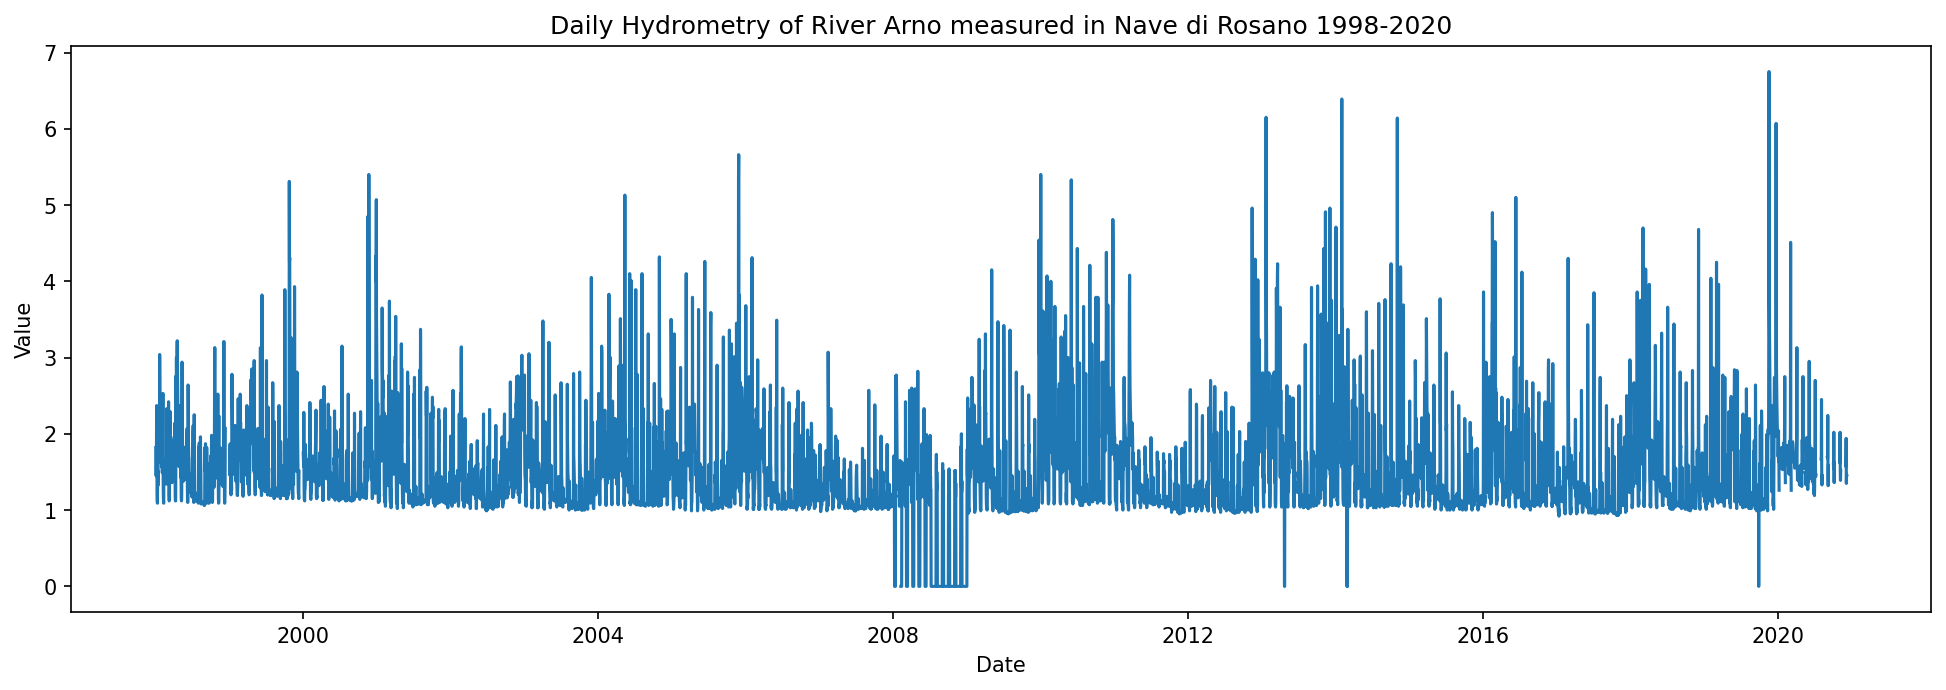

In [274]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=150):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df_all.index, y=df_all.Hydrometry_Nave_di_Rosano, title='Daily Hydrometry of River Arno measured in Nave di Rosano 1998-2020')

Seasonal Plot


In [275]:
def boxplot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=150):
    fig = plt.figure(figsize=(16,10), dpi=dpi)
    sns.boxplot(x=x, y=y, data=df)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

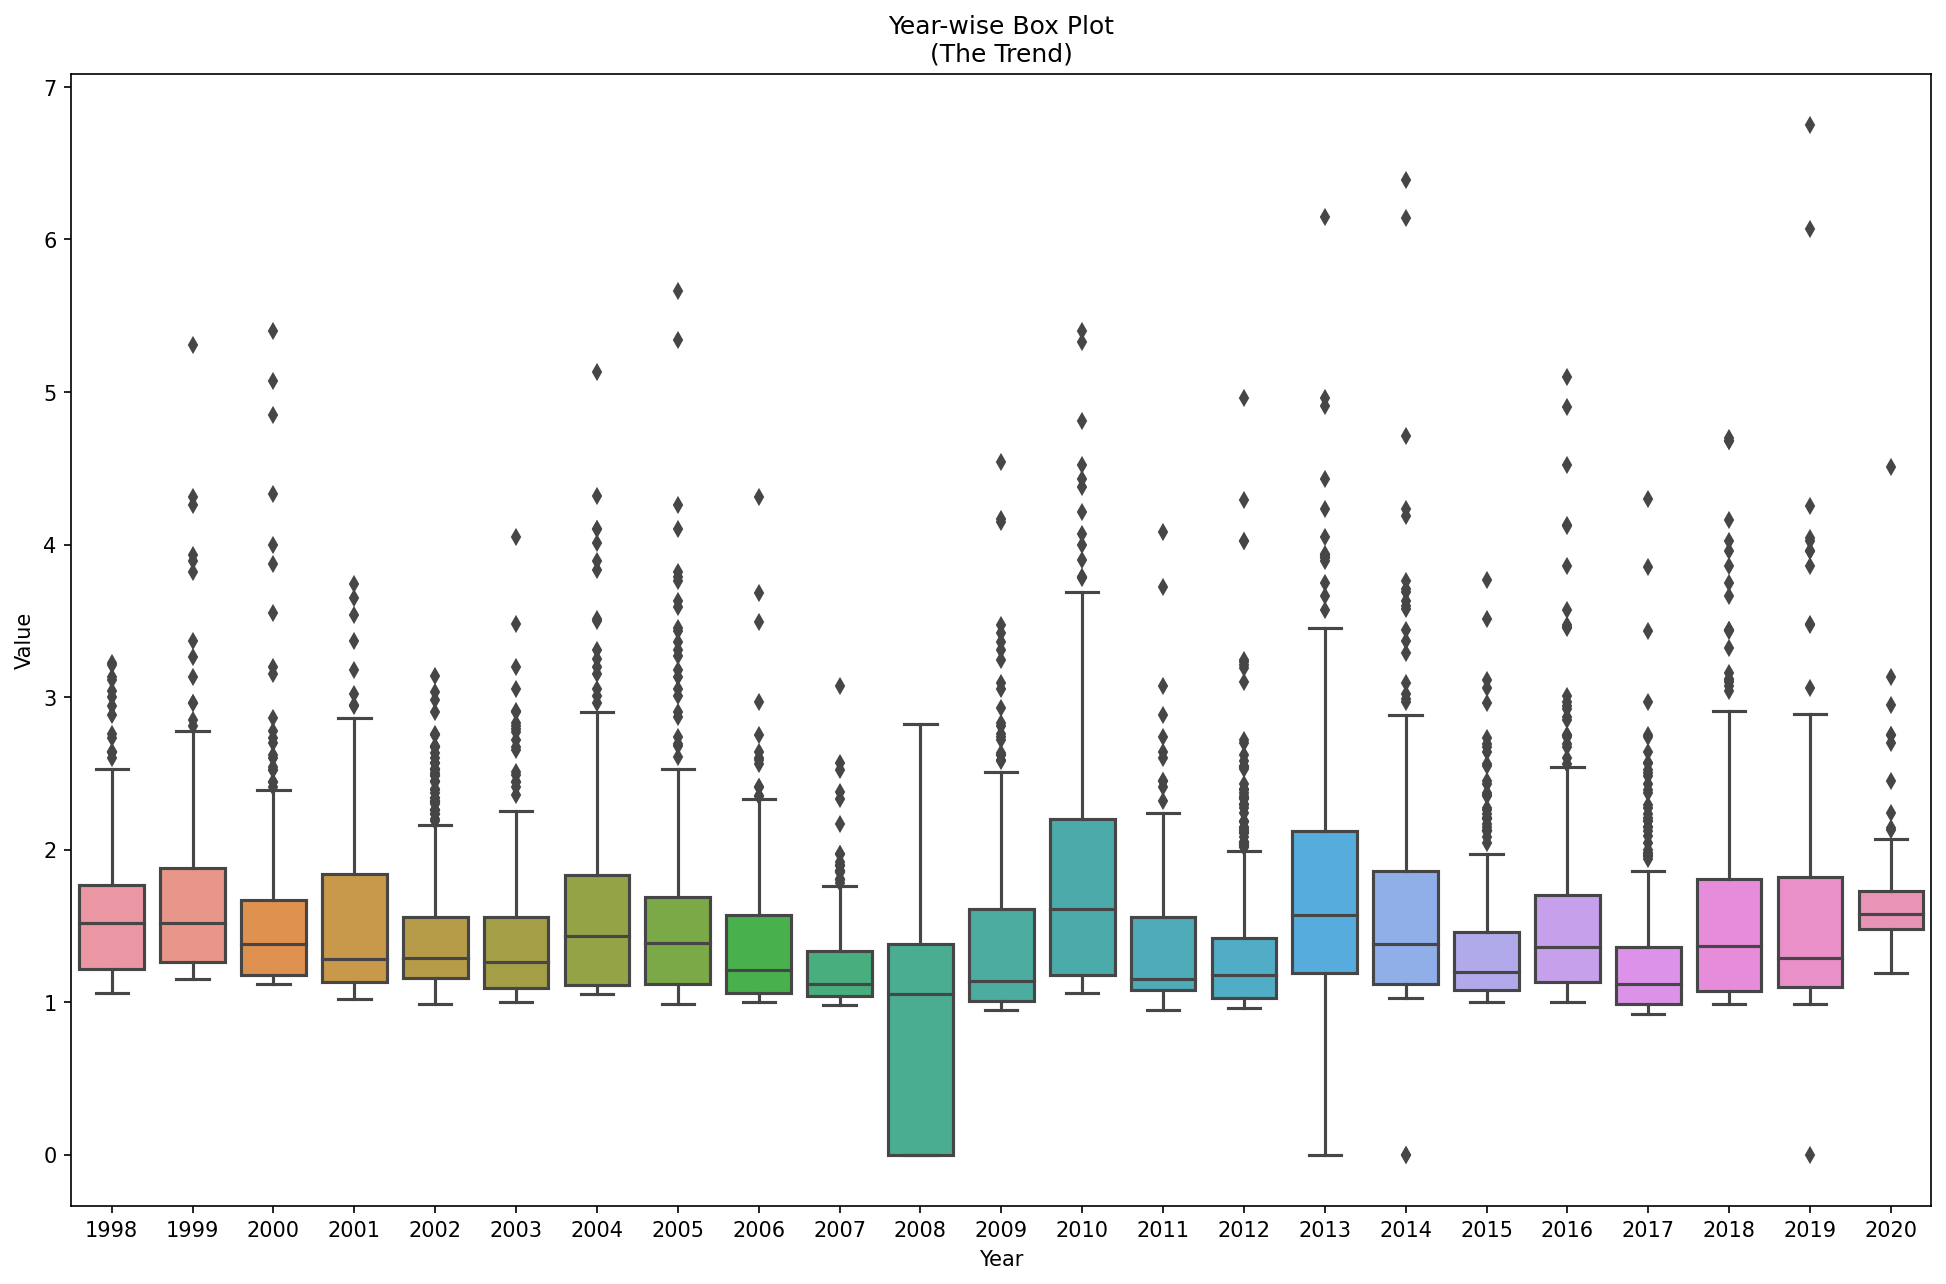

In [276]:
boxplot_df(df_all, 'Year', 'Hydrometry_Nave_di_Rosano', 'Year-wise Box Plot\n(The Trend)', 'Year')

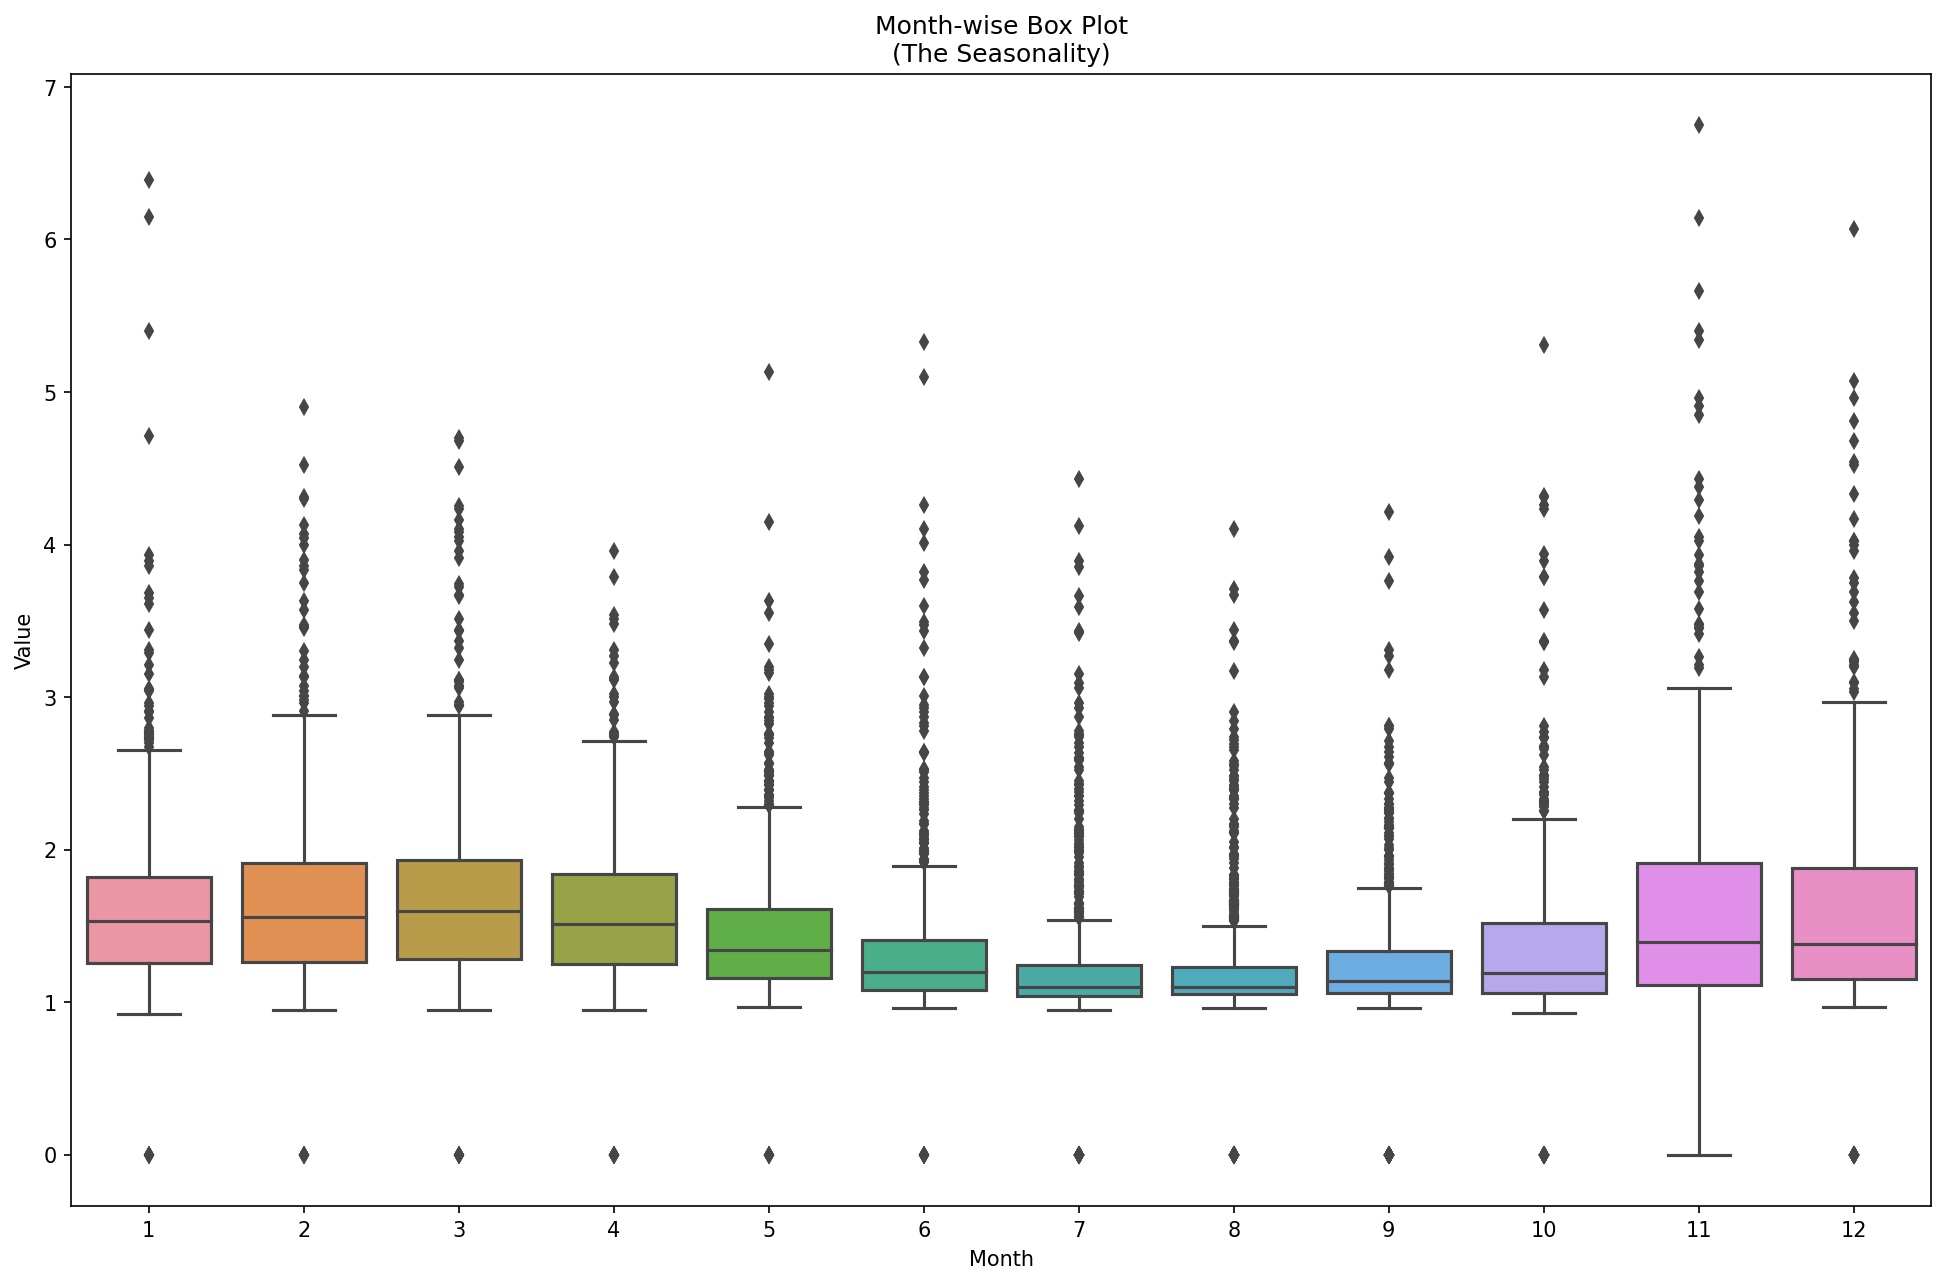

In [277]:
boxplot_df(df_all, 'Month', 'Hydrometry_Nave_di_Rosano', 'Month-wise Box Plot\n(The Seasonality)', 'Month')

https://www.machinelearningplus.com/time-series/time-series-analysis-python/


6. Additive and multiplicative time series

In [278]:
def decompose_time_series(time_series, model='', period='', dpi=150):
    if bool(period):
      decomposition = seasonal_decompose(time_series, model=model, period=period, extrapolate_trend='freq')
    else:
      decomposition = seasonal_decompose(time_series, model=model, extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches((16, 9))
    fig.set_dpi(dpi)
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    return decomposition

# Time Series Hydrometry Decomposition 

In [279]:
df_hydrometry_time_series = df_all['Hydrometry_Nave_di_Rosano']

# Filling missing values with the use of Last Observation Carried Forward

df_hydrometry_time_series= df_hydrometry_time_series.ffill()
df_hydrometry_time_series.isnull().sum()

0

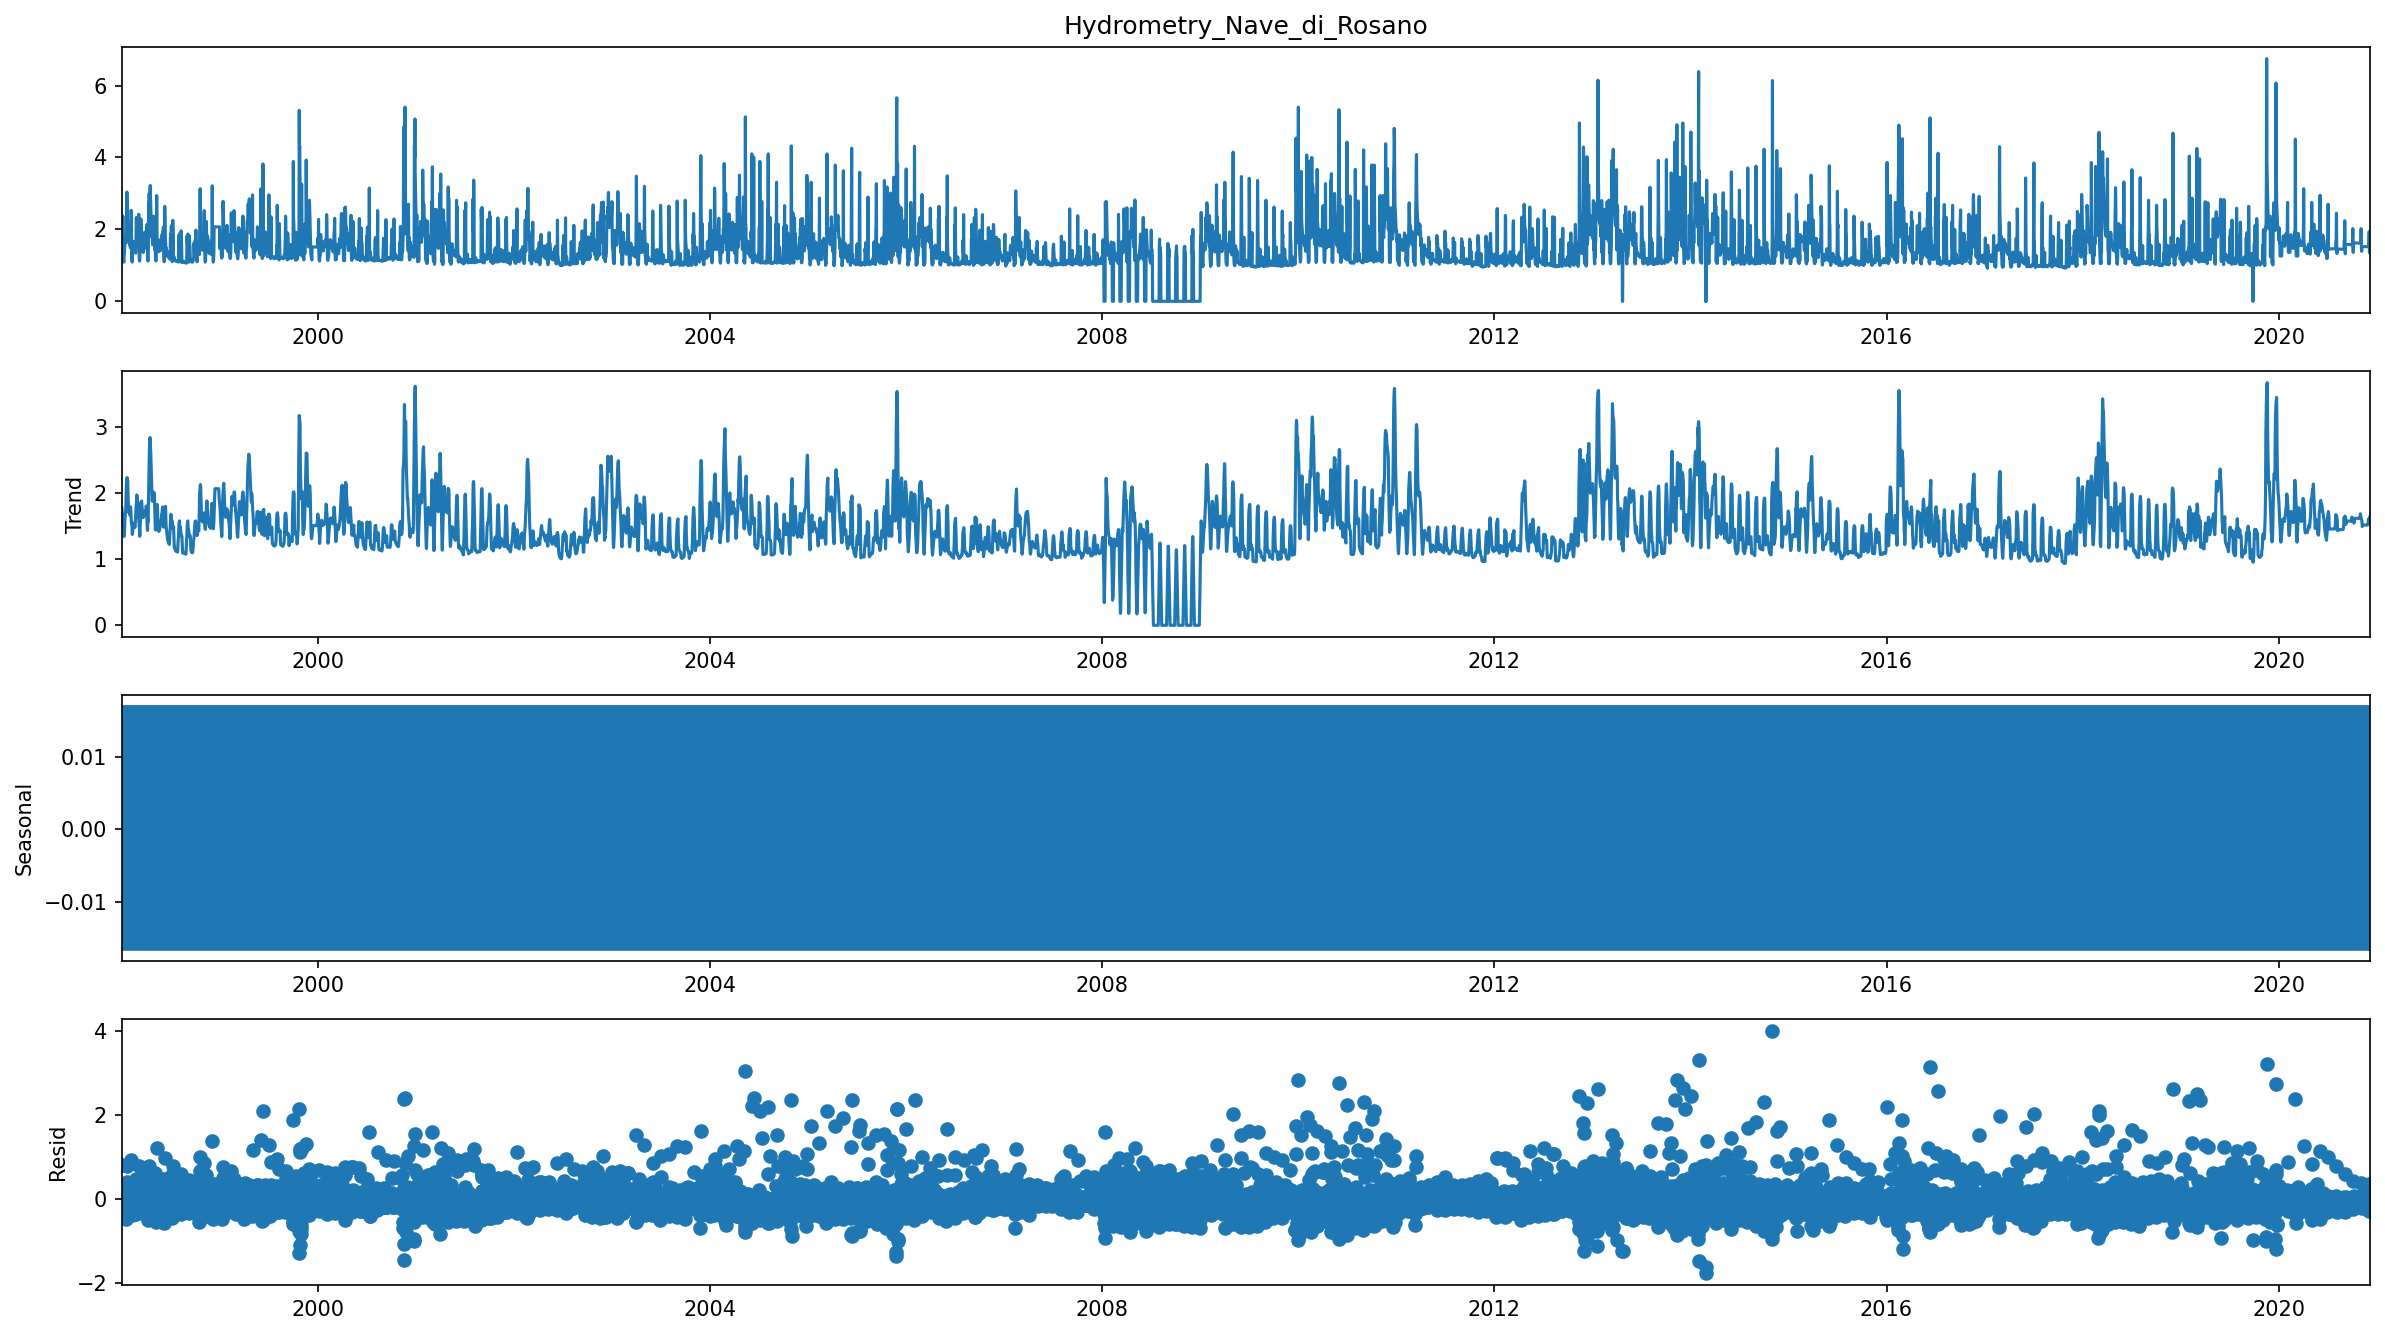

In [280]:
# Multiplicative Decomposition (commented due to existed values equals zero which can not exist in multiplicative decomposition)
# multiply_decomp = decompose_time_series(df_hydrometry_time_series,'multiplicative')

# Additive Decomposition
add_decomp = decompose_time_series(df_hydrometry_time_series,'additive')

# Time Series Hydrometry Aggregated by Week Decomposition

In [281]:
df_without_index = df_all.reset_index(level=[0])
df_without_index

,index,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,...,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano,Day,Month,Year,DayOfYear,WeekOfYear
0,1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.82,1,1,1998,1,1
1,1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.45,2,1,1998,2,1
2,1998-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.45,3,1,1998,3,1
3,1998-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.70,4,1,1998,4,1
4,1998-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.37,5,1,1998,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8371,2020-12-02,1.0,1.4,3.0,7.6,1.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.65,2,12,2020,337,49
8372,2020-12-03,0.0,0.0,0.2,1.0,0.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.94,3,12,2020,338,49
8373,2020-12-04,0.2,0.2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.35,4,12,2020,339,49
8374,2020-12-05,0.0,0.0,0.0,0.0,0.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.47,5,12,2020,340,49


In [282]:
df_without_index['WeekDate'] = df_without_index.apply(lambda column: column['index'] - dt.timedelta(days=column['index'].weekday()), axis=1)
df_without_index = df_without_index[['Hydrometry_Nave_di_Rosano','WeekDate']]

df_group_by_week_hydrometry = df_without_index.groupby(['WeekDate']).mean()
df_group_by_week_hydrometry = df_group_by_week_hydrometry.ffill()
df_group_by_week_hydrometry

,Hydrometry_Nave_di_Rosano
WeekDate,
1997-12-29,1.605000
1998-01-05,1.462857
1998-01-12,1.714286
1998-01-19,2.227143
1998-01-26,1.738571
...,...
2020-11-02,1.624000
2020-11-09,1.624000
2020-11-16,1.624000


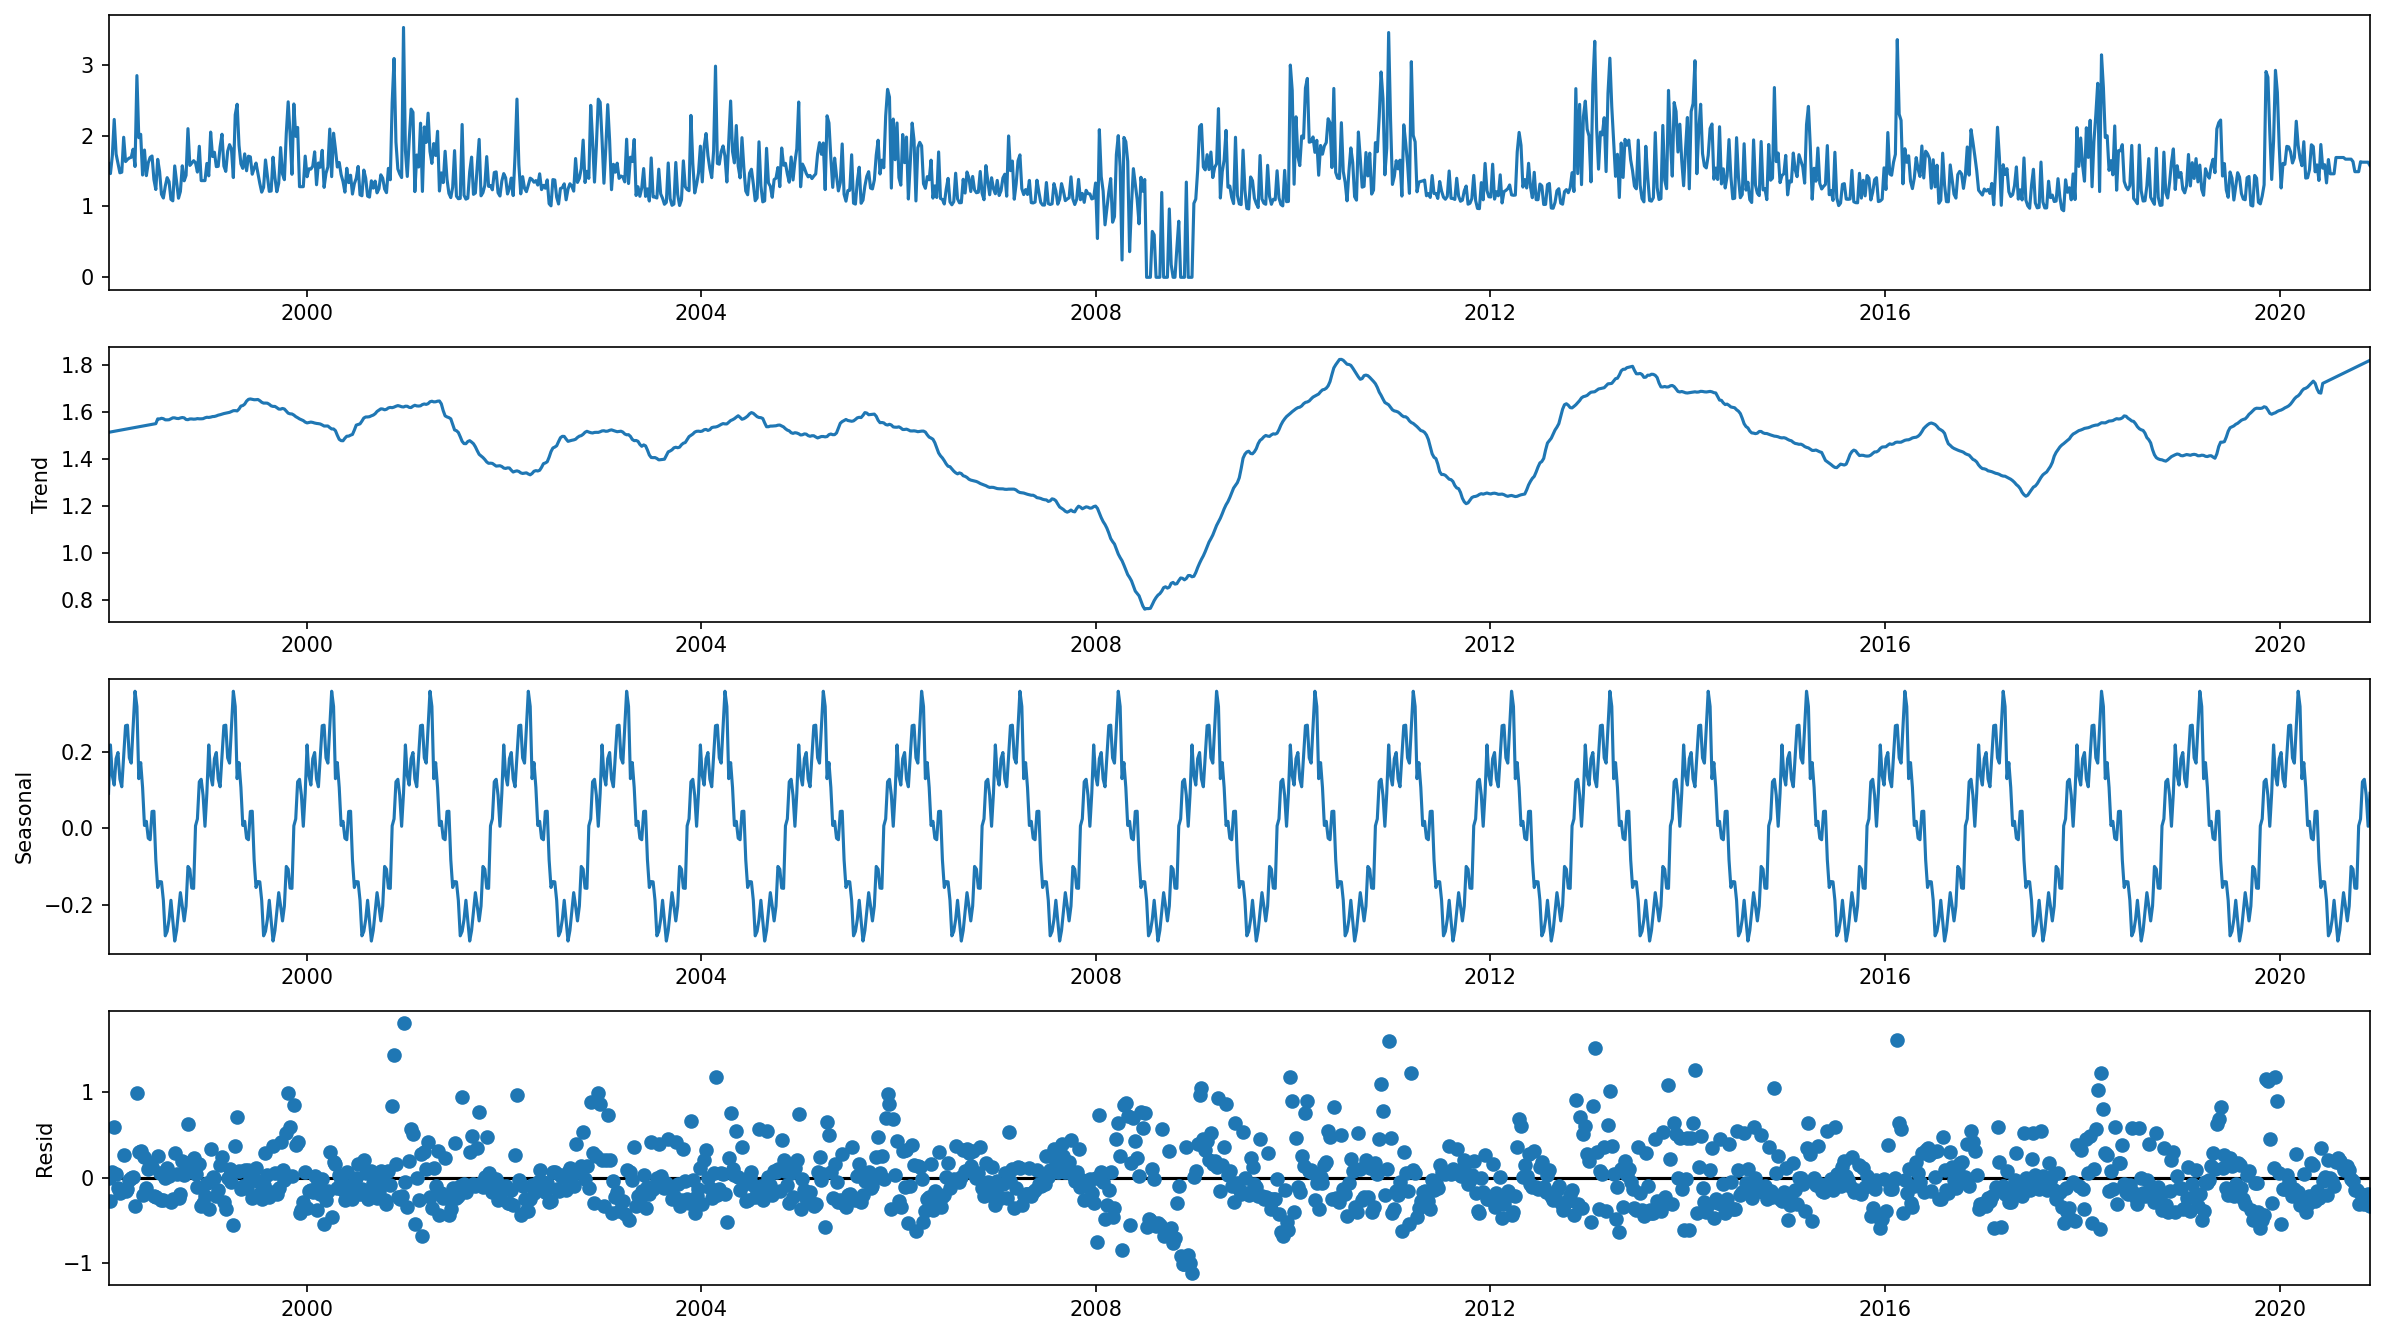

In [283]:
# Multiplicative Decomposition (commented due to existed values equals zero which can not exist in multiplicative decomposition)
# multiply_decomp = decompose_time_series(df_group_by_week_hydrometry,'multiplicative')

# Additive Decomposition
add_decomp = decompose_time_series(df_group_by_week_hydrometry,'additive',52)

# Time Series Hydrometry in 2014 Decomposition 

In [284]:
df_2014 = df_all.loc[df_all['Year'].isin([2014])]

df_2014 = df_2014['Hydrometry_Nave_di_Rosano']

# Filling missing values with the use of Last Observation Carried Forward

df_2014 = df_2014.ffill()
df_2014.isnull().sum()

0

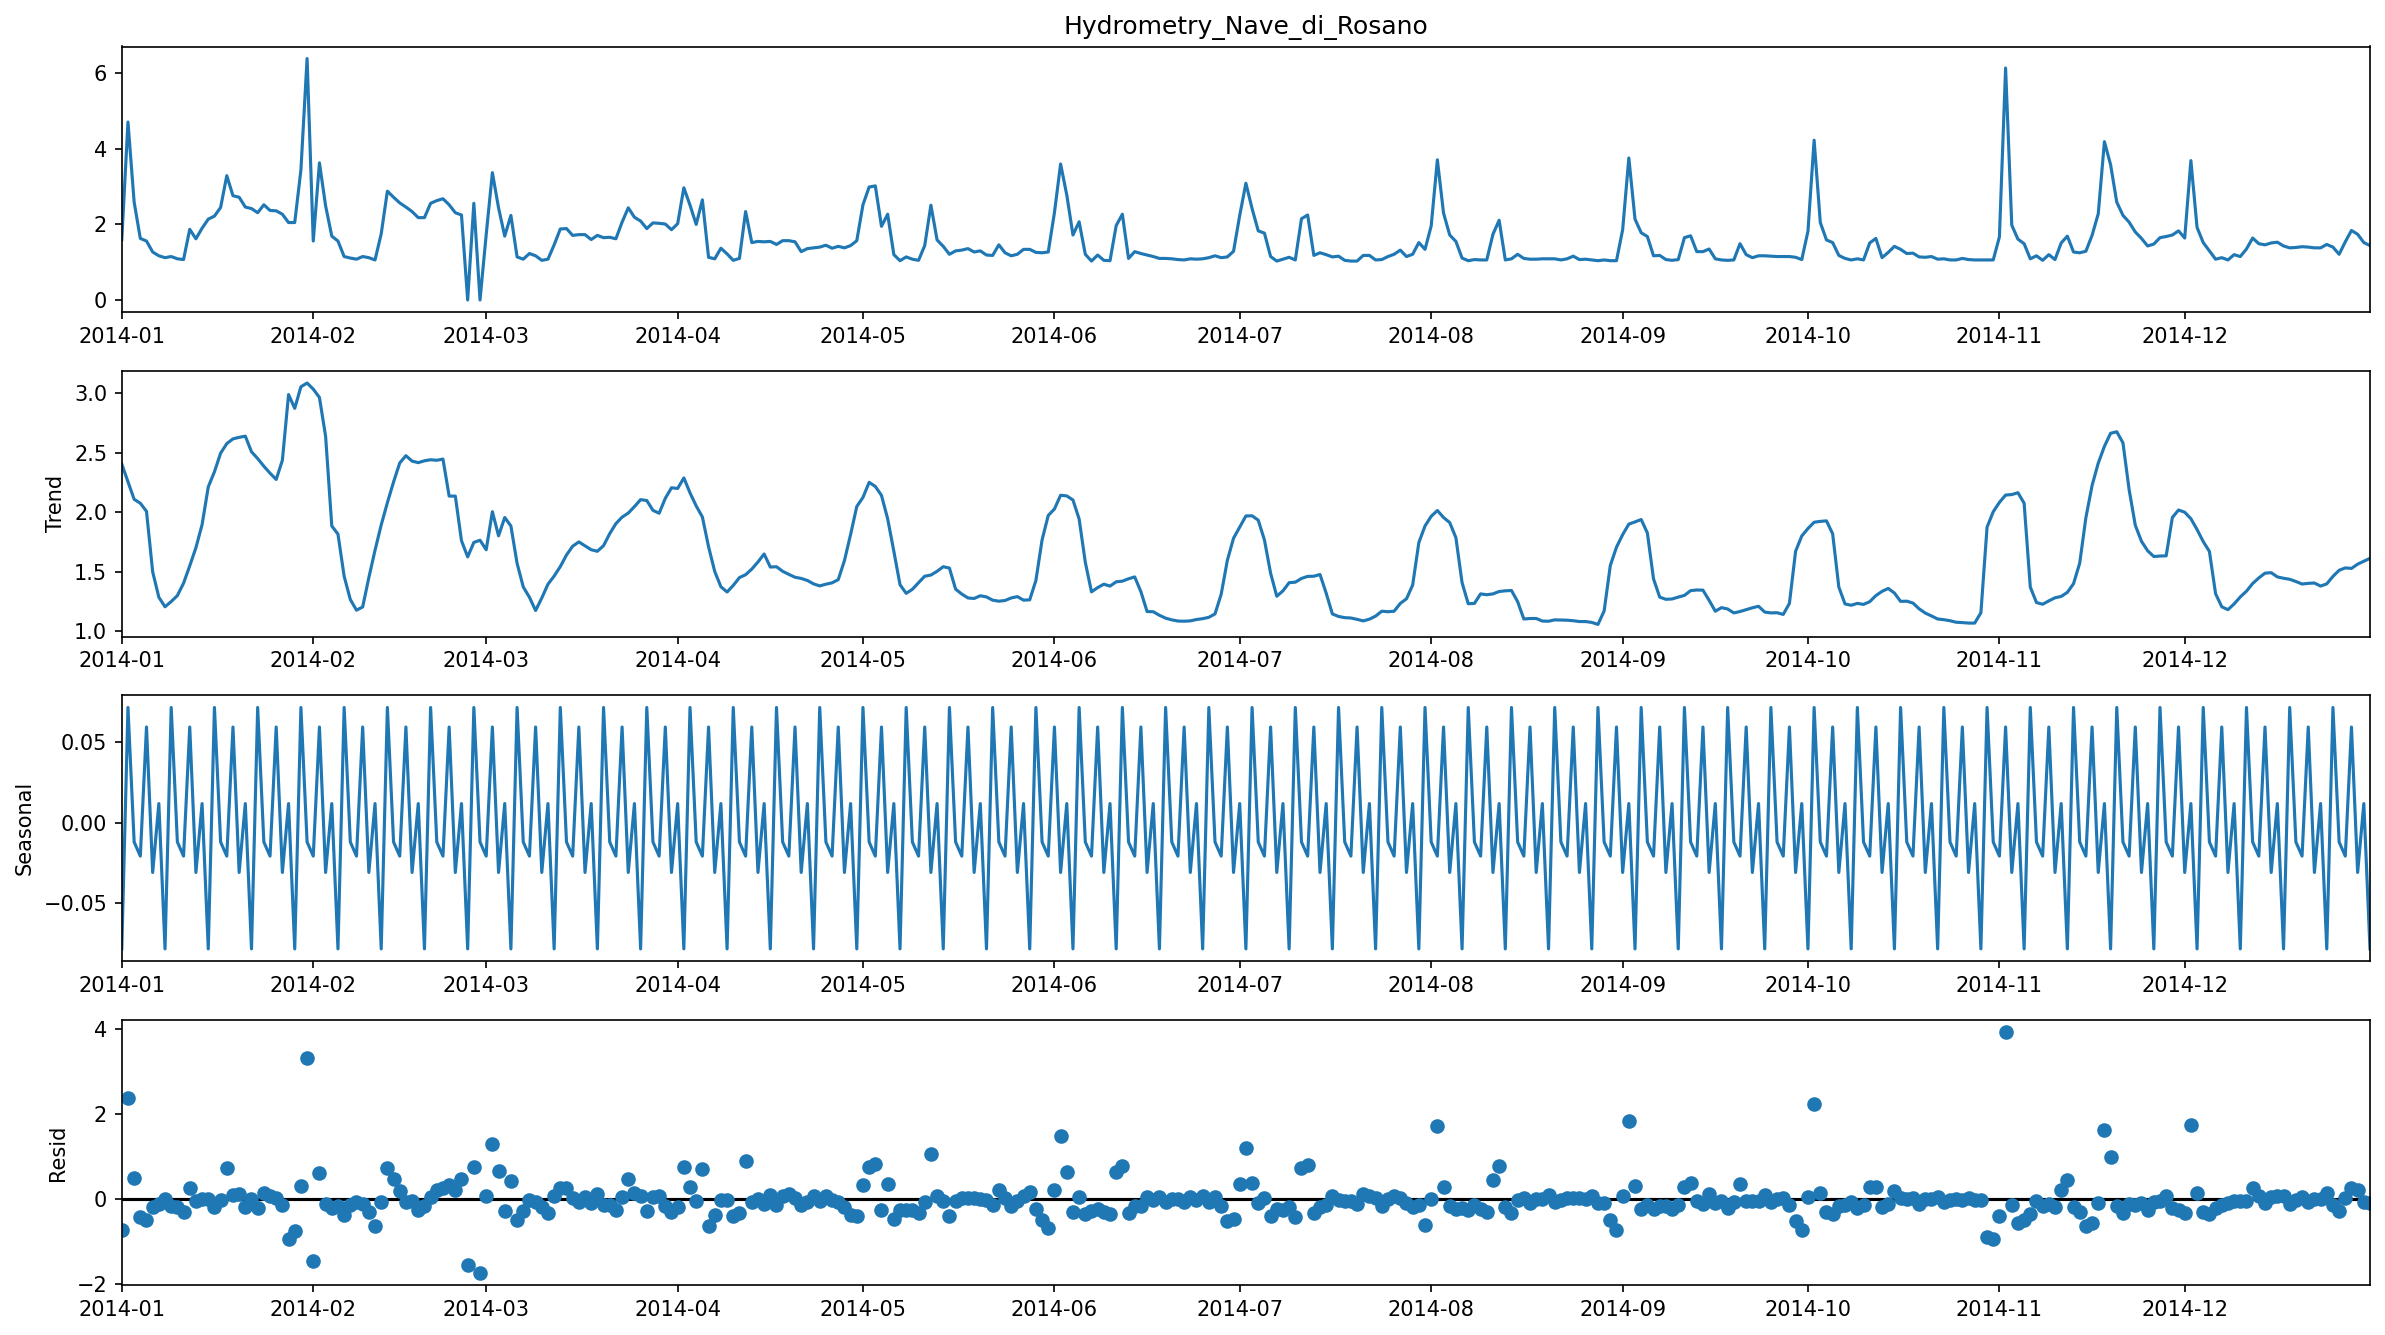

In [285]:
# Additive Decomposition
add_decomp = decompose_time_series(df_2014,'additive')

# Stationary and Non-stationary Time Series

In [286]:
df_all_filled = df_all['Hydrometry_Nave_di_Rosano'].ffill()


In [287]:
# ADF Test
result = adfuller(df_all_filled.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.74004221743329
p-value: 3.1356384455892985e-09
Critial Values:
   1%, -3.4311340480795014
Critial Values:
   5%, -2.861886495033747
Critial Values:
   10%, -2.5669544344587605


In [288]:
# KPSS Test
result = kpss(df_all_filled.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.362530
p-value: 0.093306
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


# Detrend a hydrometry time series

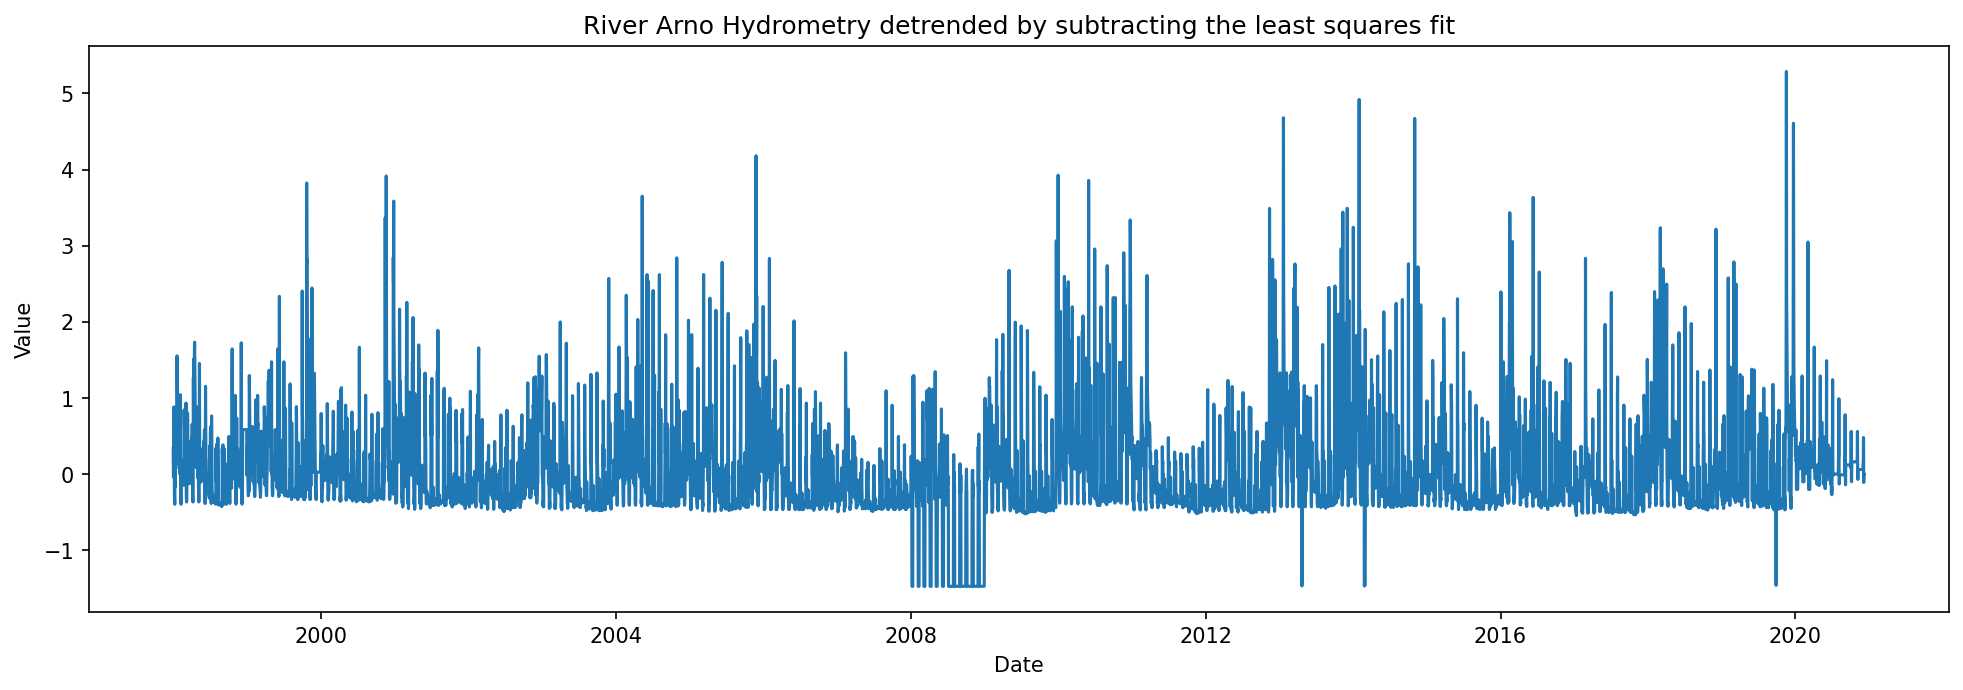

In [289]:
detrended = signal.detrend(df_all_filled.values)
plot_df(df_all_filled.index, detrended, 'River Arno Hydrometry detrended by subtracting the least squares fit')


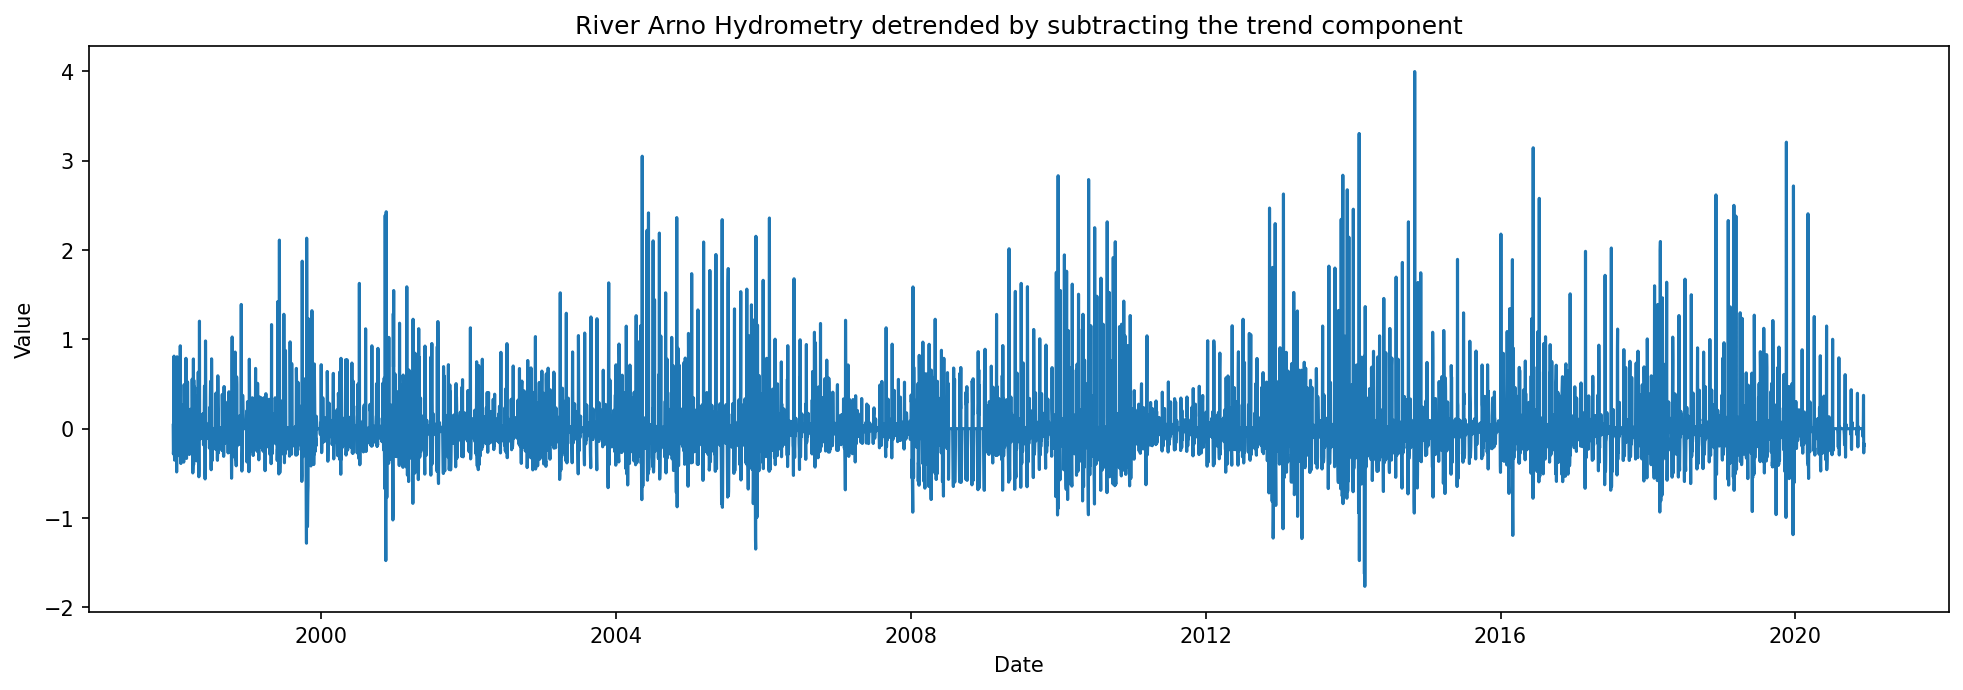

In [290]:
# Using statmodels: Subtracting the Trend Component.

# Additive Decomposition
add_decomp = seasonal_decompose(df_all_filled, model='additive', extrapolate_trend='freq')

detrended = df_all_filled.values - add_decomp.trend
plot_df(df_all_filled.index, detrended, 'River Arno Hydrometry detrended by subtracting the trend component')

# Deseasonalize a time series

https://www.machinelearningplus.com/time-series/time-series-analysis-python/


13. How to deseasonalize a time series?

In [291]:
%cd /content/drive/MyDrive/PK Data Science/master/codes/water_availability_prediction_in_Italy/

/content/drive/MyDrive/PK Data Science/master/codes/water_availability_prediction_in_Italy
